<a href="https://colab.research.google.com/github/packetech/baracuda/blob/master/capstoneNLP_FinalSubmission_MasterVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1>**Capstone Project NLP**</H1>
<b>Automatic Incident Management Ticket Sorting

<h2> <pre>CONTENT:
01-NLP Project Notes1
01-NLP Project Notes2
01-NLP Project Notes3
FINAL PRESENTATION</pre><h2>



<h2>01-NLP Project Notes 1</h2>


In [1]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


######**Exploratory Data Analysis**

Read the DataSet file "input_data.xlsx". Explore the data and get some insights about the data

In [ ]:
#!pip uninstall tensorflow

In [ ]:
#!pip install tensorflow==2.0.0

In [2]:
# Load required libraries

import pandas as pd
import numpy as np
from numpy import array
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler


import re

from pickle import dump, load

import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('wordnet')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
#Set project path 
project_path = "/content/drive/My Drive/AIML/CapstoneProjectNLP/"

In [ ]:
# Read data
capstoneNLP_DF = pd.read_excel(project_path+'input_data.xlsx')

In [ ]:
# Display shape and header

print(capstoneNLP_DF.shape)
capstoneNLP_DF.head()

(8500, 4)


,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [ ]:
# Descriptive statistics gives us a lot more insight, just like knowing that 2,948 Callers generated these 8,491 tickets
capstoneNLP_DF.describe().T

,count,unique,top,freq
Caller,8491,2948,bpctwhsn kzqsbmtp,810
AssigGrp,8491,74,GRP_0,3968
Text,8491,7887,windows password resetwindows password reset,29


#####**Concatenate necessary fields and drop unnecessary ones**

Not all the source text is important, so we need to concatenate the useful ones and drop the un-necessary ones.

In [ ]:
# Concatenate fields
capstoneNLP_DF['Text'] = capstoneNLP_DF['Short description'] + capstoneNLP_DF['Description']

# Dropping unnecessary fields
capstoneNLP_DF = capstoneNLP_DF.drop(['Short description','Description'], 1)

# Renaming the "Assignment group" for ease of usage
capstoneNLP_DF = capstoneNLP_DF.rename(columns = {"Assignment group": "Groups"})

capstoneNLP_DF.head()

,Caller,Groups,Text
0,spxjnwir pjlcoqds,GRP_0,login issue-verified user details.(employee# &...
1,hmjdrvpb komuaywn,GRP_0,outlook\r\n\r\nreceived from: hmjdrvpb.komuayw...
2,eylqgodm ybqkwiam,GRP_0,cant log in to vpn\r\n\r\nreceived from: eylqg...
3,xbkucsvz gcpydteq,GRP_0,unable to access hr_tool pageunable to access ...
4,owlgqjme qhcozdfx,GRP_0,skype error skype error


In [ ]:
# Check for null data
print(capstoneNLP_DF.isnull().any(axis = 0))

Caller    False
Groups    False
Text       True
dtype: bool


In [ ]:
# See how the Assignment group "Groups" stands as per number of count of records
groupy = capstoneNLP_DF.groupby('Groups').size().sort_values(ascending=False)#[:60]
groupy

Groups
GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_67       1
GRP_61       1
GRP_73       1
GRP_35       1
GRP_70       1
Length: 74, dtype: int64

#####**Observation:** 
We have 74 categories as shown above.

In [ ]:
# See how the Assignment group "Groups" stands as per number of count of records
# In 60 GRP displays we have 11 single digit; that means the rest from 61 to 74 are single digits. we have 25 single digits (i.e. 25 Groups
# have fewer incidents)
groupy = capstoneNLP_DF.groupby('Groups').size().sort_values(ascending=False)[:60]
groupy

Groups
GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
GRP_2      241
GRP_19     215
GRP_3      200
GRP_6      184
GRP_13     145
GRP_10     140
GRP_5      129
GRP_14     118
GRP_25     116
GRP_33     107
GRP_4      100
GRP_29      97
GRP_18      88
GRP_16      85
GRP_17      81
GRP_31      69
GRP_7       68
GRP_34      62
GRP_26      56
GRP_40      45
GRP_28      44
GRP_41      40
GRP_30      39
GRP_15      39
GRP_42      37
GRP_20      36
GRP_45      35
GRP_22      31
GRP_1       31
GRP_11      30
GRP_21      29
GRP_47      27
GRP_48      25
GRP_23      25
GRP_62      25
GRP_60      20
GRP_39      19
GRP_27      18
GRP_37      16
GRP_44      15
GRP_36      15
GRP_50      14
GRP_53      11
GRP_65      11
GRP_52       9
GRP_55       8
GRP_51       8
GRP_49       6
GRP_59       6
GRP_46       6
GRP_43       5
GRP_32       4
GRP_66       4
GRP_38       3
GRP_56       3
dtype: int64

In [ ]:
# See how the 'caller' attribute stands as per number of count of records
callers = capstoneNLP_DF.groupby('Caller').size().sort_values(ascending=False)#[:60]
callers

Caller
bpctwhsn kzqsbmtp    810
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    134
rbozivdq gmlhrtvp     87
rkupnshb gsmzfojw     71
                    ... 
kcldufqe xghvrzoi      1
kclhqspo xvugztyc      1
tbloeczi gxlmeyph      1
kcqzrgef awnjdlyr      1
nhixruet elnjqdwg      1
Length: 2950, dtype: int64

In [ ]:
# See how the 'caller' attribute stands as per number of count of records
callers = capstoneNLP_DF.groupby('Caller').size().sort_values(ascending=False)[:60]
callers

Caller
bpctwhsn kzqsbmtp    810
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    134
rbozivdq gmlhrtvp     87
rkupnshb gsmzfojw     71
jloygrwh acvztedi     64
spxqmiry zpwgoqju     63
oldrctiu bxurpsyi     57
olckhmvx pcqobjnd     54
dkmcfreg anwmfvlg     51
jyoqwxhz clhxsoqy     51
efbwiadp dicafxhv     45
afkstcev utbnkyop     32
gzhapcld fdigznbk     30
mnlazfsr mtqrkhnx     28
uvrbhlnt bjrmalzi     27
entuakhp xrnhtdmk     25
vzqomdgt jwoqbuml     24
jionmpsf wnkpzcmv     24
bozdftwx smylqejw     23
rxoynvgi ntgdsehl     21
qasdhyzm yuglsrwx     21
utyeofsk rdyzpwhi     21
vbwszcqn nlbqsuyv     19
ugyothfz ugrmkdhx     17
hbmwlprq ilfvyodx     17
ughzilfm cfibdamq     16
pfzxecbo ptygkvzl     16
niptbwdq csenjruz     16
vfrdxtqw jfbmsenz     16
uxgrdjfc kqxdjeov     15
mfeyouli ndobtzpw     15
ctvaejbo mjcerqwo     14
xwirzvda okhyipgr     14
obanjrhg rnafleys     13
aorthyme rnsuipbk     13
wktesmbp lorjymef     13
tqfnalpj qyoscnge     13
zuxcfonv nyhpkrbe     12
rdfjsawg zpmxgdcw 

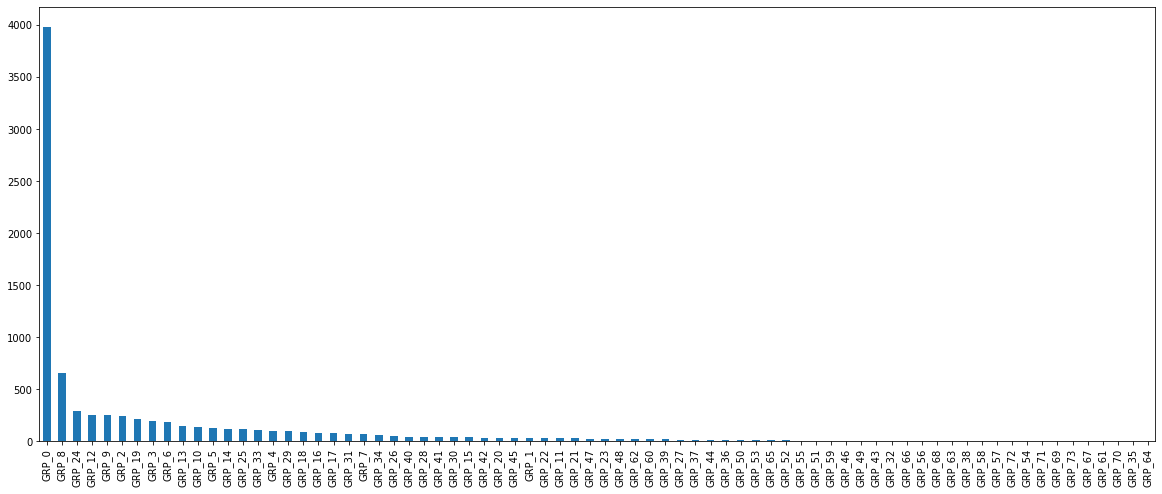

In [ ]:
# Visualize the distribution in Group assignment (which is heavily skewed)
import matplotlib.pyplot as plt
plt.figure(figsize=[20,8])
capstoneNLP_DF['Groups'].value_counts().plot(kind='bar')

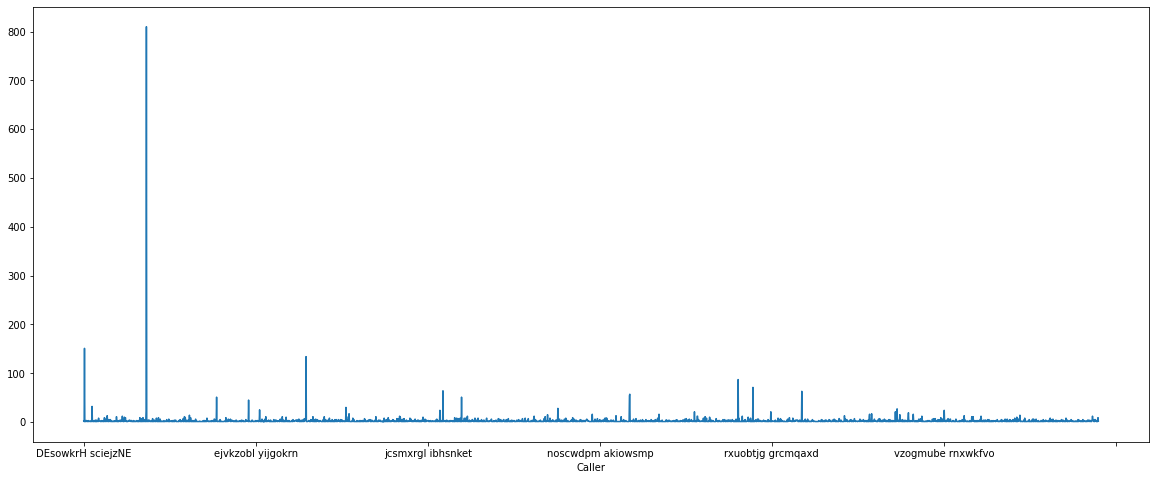

In [ ]:
# Visualize the distribution in caller attribute (apart from the highers caller, we have about 15 more who are notable)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,8))
capstoneNLP_DF.groupby(['Caller']).count()['Text'].plot(ax=ax)

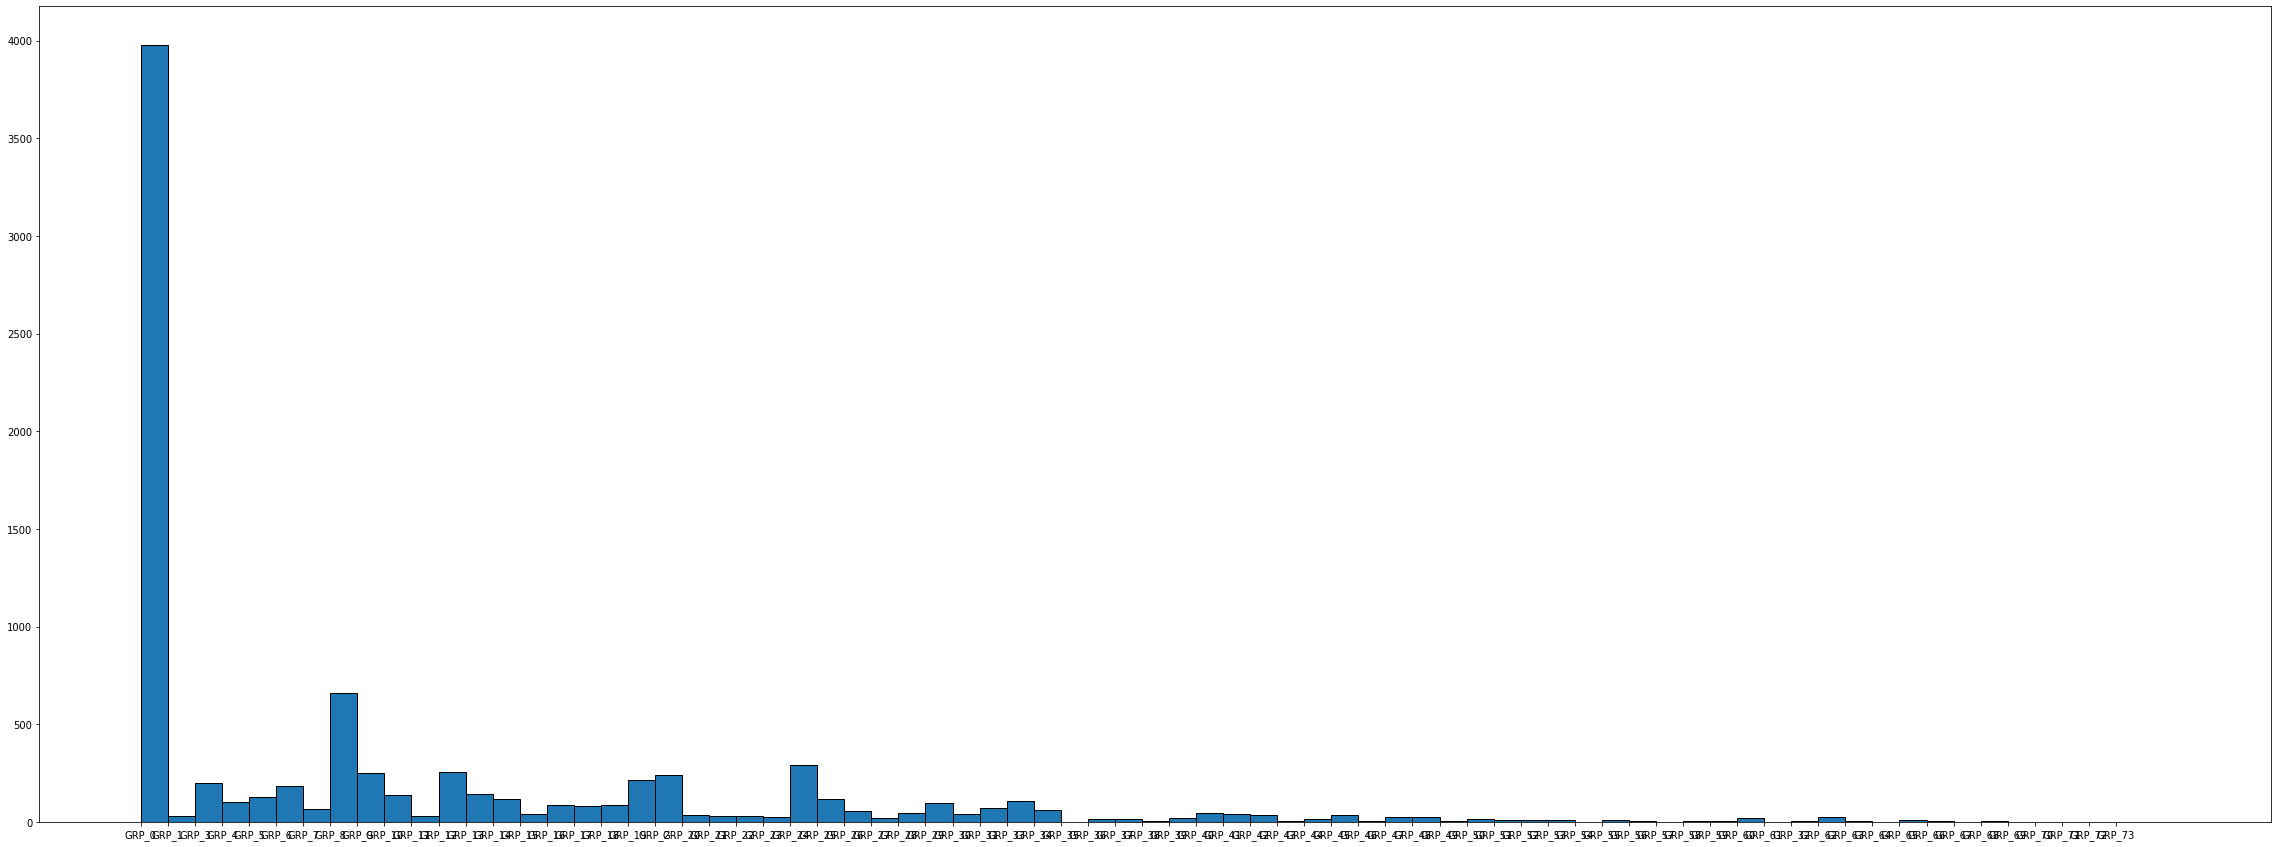

In [ ]:
# this histogram shows a little bit more about the groups
plt.figure(figsize=[40,15])
bins = [0, 1,	2,	3,	4,	5,	6,	7,	8,	9,	10,	11,	12,	13,	14,	15,	16,	17,	18,	19,	20,	21,	22,	23,	24,	25,	26,	27,	28,	29,	30,	31,	32,	33,	34,	35,	36,	37,	38,	39,	40,	41,	42,	43,	44,	45,	46,	47,	48,	49,	50,	51,	52,	53,	54,	55,	56,	57,	58,	59,	60,	61,	62,	63,	64,	65,	66,	67,	68,	69,	70,	71,	72,	73,	74,	75] # Representing the GRP_0 to GRP_70
plt.hist(capstoneNLP_DF.Groups,bins, edgecolor = 'black')
plt.show()

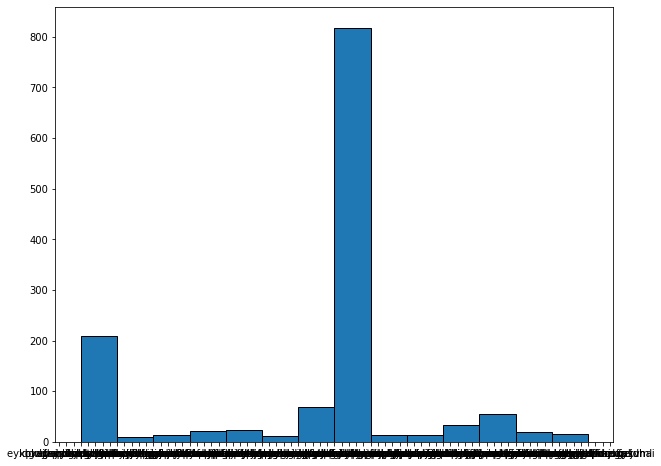

In [ ]:

# this histogram shows a little bit more about the callers
plt.figure(figsize=[10,8])
bins = [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75] # Representing the caller
plt.hist(capstoneNLP_DF.Caller,bins, edgecolor = 'black')
plt.show()

#####**Observations:**
GRP_0 greatly out weighs the rest.
It is either:
1. Process of Login is very difficult
2. The user interface is not friendly 
3. The users are novices and need lots of help or they are first timers to this type of technology

In [ ]:
# Going forward we will drop the 'Caller' attribute, which we do not need for further work
capstoneNLP_DF = capstoneNLP_DF.drop(['Caller'], 1)
capstoneNLP_DF.head()

,Groups,Text
0,GRP_0,login issue-verified user details.(employee# &...
1,GRP_0,outlook\r\n\r\nreceived from: hmjdrvpb.komuayw...
2,GRP_0,cant log in to vpn\r\n\r\nreceived from: eylqg...
3,GRP_0,unable to access hr_tool pageunable to access ...
4,GRP_0,skype error skype error


In [ ]:
###############   NLP Project Notes 1_Codes Ends Here ###############

<h2>02-NLP Project Notes 2</h2>

##**1) Model Building**
###**a) ​Prepare the data for model building. Split data into train and validation sets.**

In [ ]:
# Carry out onehot encoding of the target variable
target = pd.get_dummies(capstoneNLP_DF['Groups'])
target_labels = target.columns

In [ ]:
target.head()

,GRP_0,GRP_1,GRP_10,GRP_11,GRP_12,GRP_13,GRP_14,GRP_15,GRP_16,GRP_17,GRP_18,GRP_19,GRP_2,GRP_20,GRP_21,GRP_22,GRP_23,GRP_24,GRP_25,GRP_26,GRP_27,GRP_28,GRP_29,GRP_3,GRP_30,GRP_31,GRP_32,GRP_33,GRP_34,GRP_35,GRP_36,GRP_37,GRP_38,GRP_39,GRP_4,GRP_40,GRP_41,GRP_42,GRP_43,GRP_44,GRP_45,GRP_46,GRP_47,GRP_48,GRP_49,GRP_5,GRP_50,GRP_51,GRP_52,GRP_53,GRP_54,GRP_55,GRP_56,GRP_57,GRP_58,GRP_59,GRP_6,GRP_60,GRP_61,GRP_62,GRP_63,GRP_64,GRP_65,GRP_66,GRP_67,GRP_68,GRP_69,GRP_7,GRP_70,GRP_71,GRP_72,GRP_73,GRP_8,GRP_9
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
target_labels

Index(['GRP_0', 'GRP_1', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2', 'GRP_20',
       'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25', 'GRP_26', 'GRP_27',
       'GRP_28', 'GRP_29', 'GRP_3', 'GRP_30', 'GRP_31', 'GRP_32', 'GRP_33',
       'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38', 'GRP_39', 'GRP_4',
       'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44', 'GRP_45', 'GRP_46',
       'GRP_47', 'GRP_48', 'GRP_49', 'GRP_5', 'GRP_50', 'GRP_51', 'GRP_52',
       'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56', 'GRP_57', 'GRP_58', 'GRP_59',
       'GRP_6', 'GRP_60', 'GRP_61', 'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65',
       'GRP_66', 'GRP_67', 'GRP_68', 'GRP_69', 'GRP_7', 'GRP_70', 'GRP_71',
       'GRP_72', 'GRP_73', 'GRP_8', 'GRP_9'],
      dtype='object')

In [ ]:
#Let's remove all the records where any row contain a null value or empty string.
print(capstoneNLP_DF["Text"][468])

job Job_485 failed in job_scheduler at: 10/25/2016 02:33:00  received from: monitoring_tool@company.com

job Job_485 failed in job_scheduler at: 10/25/2016 02:33:00


In [ ]:
#Let's see the associated labels with this Text
print("Group:" + str(capstoneNLP_DF["Groups"][468]))

Group:GRP_8


#####**Creating Multi-label Text Classification Model**

There are two ways to create multi-label classification models: Using single dense output layer and using multiple dense output layers(we have 74 dim, so we will use only single dense output)

Using a single dense layer with 74 outputs with a sigmoid activation functions and binary cross entropy loss functions. Each neuron in the output dense layer will represent one of the 74 output labels. The sigmoid activation function will return a value between 0 and 1 for each neuron. If any neuron's output value is greater than 0.5, it is assumed that the description belongs to the class represented by that particular neuron.

#####**Text cleaning and preprocessing**

In [ ]:
# As always, the first step in the text classification model is to create a function responsible for cleaning the text

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
X = []
sentences = list(capstoneNLP_DF["Text"])
for sen in sentences:
  X.append(preprocess_text(str(sen)))

y = target.values

#####**Dataset splitting and encoding**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [ ]:
# We need to convert text inputs into embedded vectors

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

###**b) ​Creating the network and compile the model. Print the model summary. Create the train and the validation generator and fit the model**

#####**Get Glove Word Embeddings**
Note: There are a lot of other encoding techniques available and may be applied depending on the type of problem — for example : CountVectorizer, tfidf vectorizer, word embeddings using pre-trained models like GloVe, Word2Vec etc.
We are considering the complex encoding for this particular classification problem for the sake of not just examination of occurrences of words (which is what CountVectorizer would do) but of their relative order and position/context; therefore we are doing word embeddings using a downloaded GloVe on LSTM.

In [ ]:
# We will be using GloVe word embeddings to convert text inputs to their numeric counterparts.

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open(project_path+'glove.6B.200d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 200))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
len(embeddings_dictionary.values())

400000

The following script creates the model. Our model will have one input layer, one embedding layer, one LSTM layer with 128 neurons and one output layer with 74 neurons since we have 74 labels in the output.

#####**The Model**

In [ ]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 200, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(74, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
# Let's print the model summary:
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 200)          3081800   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
dense (Dense)                (None, 74)                9546      
Total params: 3,259,794
Trainable params: 177,994
Non-trainable params: 3,081,800
_________________________________________________________________
None


#####**The architecture of our LSTM network**

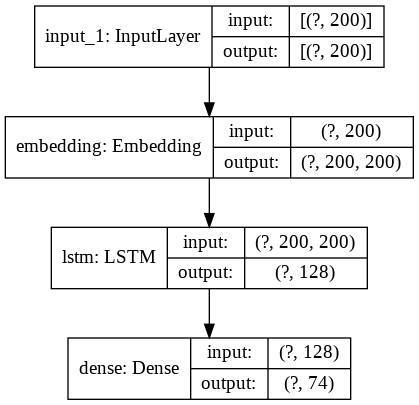

In [ ]:
# The following script prints the architecture of our neural network:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
# From the figure above, you can see that the output layer only contains 1 dense layer with 74 neurons. Let's now train our model:

history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
43/43 [==============================] - 1s 33ms/step - loss: 0.2850 - acc: 0.3009 - val_loss: 0.0519 - val_acc: 0.4868
Epoch 2/10
43/43 [==============================] - 1s 24ms/step - loss: 0.0504 - acc: 0.4693 - val_loss: 0.0472 - val_acc: 0.4868
Epoch 3/10
43/43 [==============================] - 1s 23ms/step - loss: 0.0487 - acc: 0.4693 - val_loss: 0.0466 - val_acc: 0.4868
Epoch 4/10
43/43 [==============================] - 1s 24ms/step - loss: 0.0483 - acc: 0.4693 - val_loss: 0.0464 - val_acc: 0.4868
Epoch 5/10
43/43 [==============================] - 1s 24ms/step - loss: 0.0479 - acc: 0.4693 - val_loss: 0.0462 - val_acc: 0.4868
Epoch 6/10
43/43 [==============================] - 1s 23ms/step - loss: 0.0478 - acc: 0.4693 - val_loss: 0.0461 - val_acc: 0.4868
Epoch 7/10
43/43 [==============================] - 1s 24ms/step - loss: 0.0472 - acc: 0.4693 - val_loss: 0.0459 - val_acc: 0.4868
Epoch 8/10
43/43 [==============================] - 1s 24ms/step - loss: 0.0464 - a

##**2)Model Evaluation**

#####**a) ​Evaluating the model using the plots for the loss, accuracy and other metrics identified**

In [ ]:
# Let's now evaluate our model on the test set:

score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

54/54 [==============================] - 0s 6ms/step - loss: 0.0472 - acc: 0.4476
Test Score: 0.0471595898270607
Test Accuracy: 0.4476470649242401


Our model achieves an accuracy of around 45% which is pretty poor.

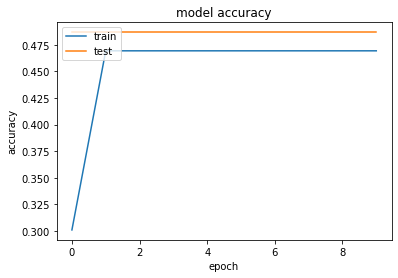

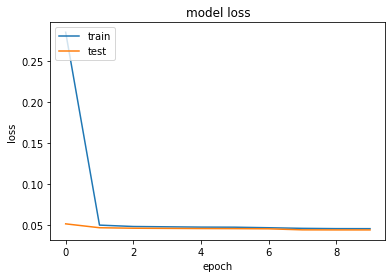

In [ ]:
# Finally, we will plot the loss and accuracy values for training and test sets to see what happened to our model

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

#####**Observation**

From the output we can see that the accuracy for test (validation) set doesn't converge after the first epochs. Also, the difference between training and validation loss is very minimal. Therefore, the model starts to underfit after the first epochs and hence we get a poor performance on unseen test set

#####**b) ​Predict on a batch of text descriptions. Identify the areas of improvement for the next iterations**

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

Y_pred = model.predict(X_test)
y_pred = np.rint(Y_pred)
#y_test = np.array(y_test)
y_pred = np.argmax(Y_pred,axis=1)
y_test = np.argmax(y_test,axis=1)
print('  Classification Report:\n',classification_report(y_test,y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       0.45      1.00      0.62       761
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00        42
           5       0.00      0.00      0.00        26
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00        20
           9       0.00      0.00      0.00        17
          10       0.00      0.00      0.00        18
          11       0.00      0.00      0.00        58
          12       0.00      0.00      0.00        51
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         7
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         3
 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#####**Observation**
The above warning means that some labels are only present in train data and some labels are only present in test dataset.
This we should be handle via upsampling during further iterations (because some classes have only one record entry)

#####**Areas of improvement for the next iterations will be:**

1. We will try to normalize the data, using stemming or lematization and even remove stopwords
2. There exist a great imbalance in the classes when we groupby the assigned group (GRP_0 count value is 3968 while a few others are 3 digits and majority are just 2 digits though we have also a single digit ). So we will try to handle the imbalance in the dataset
3. We will also try another pre-trained word embedding Glove model with more word handling capabilities (e.g. higher than 400,000)
4. We may increase the number of words in the tokenizer to see what happens
5. The LSTM model will be made complex
6. Then finally we will do more iterations (higher epochs)


In [ ]:
###############   NLP Project Notes 2_Codes Ends Here ###############


<h2>03-NLP Project Notes 3</h2>


##**( 1 ) Fine-tuning the model​:** 

##**a. Reiterate the modelling process keeping in mind the areas of improvement**

##**b. Highlight and provide commentary on the steps taken to arrive at the improved model**
 
Please Note: We are going to try to simultaneously perform a and b. And we are going to number them as we proceed.
Also keep in mind that in our milestone-2 our model had 45% performance 
###**Please Note: after some data handling techniques, model improvement via some hyper-parameter adjustments and several iterations; we achieved a performance of 97%**

###**We begin from here onward to enumerate what was done to improve on our model performance**

###**1. Tensorflow version 2.0.0 is installed, and because keras will not work with this out of the box, we have to use tensorflow keras libraries**

###**2. We reduced our classes by filtering out to what we call 'GRP_Others' those classes with very few samples (this is the help us when we are taking care of class imbalance, find the reason why in the imbalance treatment section below)**

In [ ]:
#We filter out classes with 1 - 6 samples
capstoneNLP_DF_LTS = capstoneNLP_DF[capstoneNLP_DF['Grps'].map(capstoneNLP_DF['Grps'].value_counts()) < 7]

In [ ]:
groupy2 = capstoneNLP_DF_LTS.groupby('Grps').size().sort_values(ascending=False)
groupy2

In [ ]:
# Replacing the groups that are now seen in groupy2 anyhwere they are found in the main dataset (capstoneNLP_DF) calling them GRP_OTHERS

capstoneNLP_DF_prep = capstoneNLP_DF.replace({'GRP_59':'GRP_OTHERS','GRP_46':'GRP_OTHERS','GRP_49':'GRP_OTHERS','GRP_43':'GRP_OTHERS','GRP_66':'GRP_OTHERS','GRP_32':'GRP_OTHERS','GRP_68':'GRP_OTHERS','GRP_63':'GRP_OTHERS','GRP_58':'GRP_OTHERS','GRP_56':'GRP_OTHERS','GRP_38':'GRP_OTHERS','GRP_72':'GRP_OTHERS','GRP_57':'GRP_OTHERS','GRP_54':'GRP_OTHERS','GRP_69':'GRP_OTHERS','GRP_71':'GRP_OTHERS','GRP_67':'GRP_OTHERS','GRP_64':'GRP_OTHERS','GRP_61':'GRP_OTHERS','GRP_70':'GRP_OTHERS','GRP_35':'GRP_OTHERS','GRP_73':'GRP_OTHERS'})

# 'GRP_51':'GRP_OTHERS','GRP_55':'GRP_OTHERS','GRP_52':'GRP_OTHERS','GRP_53':'GRP_OTHERS','GRP_65':'GRP_OTHERS','GRP_50':'GRP_OTHERS','GRP_44':'GRP_OTHERS','GRP_36':'GRP_OTHERS',

In [ ]:
capstoneNLP_DF_prep.tail()

In [ ]:
# check and remove NAN
print(capstoneNLP_DF_prep.isnull().any(axis = 0))

In [ ]:
capstoneNLP_DF_prep = capstoneNLP_DF_prep.dropna()
print(capstoneNLP_DF_prep.isnull().any(axis = 0))

In [ ]:
# Converting categrical labels to numerical format and call them 'Target'
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(capstoneNLP_DF_prep['Grps'])
capstoneNLP_DF_prep['Target'] = le.transform(capstoneNLP_DF_prep['Grps'])
capstoneNLP_DF_prep.tail()

###**3. Performing text pre-processing (by text lowering, noise/stopwards removal and normalization by stemming)**

In [ ]:
# text lower casing
capstoneNLP_DF_prep['Desc']=[word.lower() for word in capstoneNLP_DF_prep['Desc']]

In [ ]:
# Noise/ stopwords removal and stemming(which is normalization)
stem_word =[]
snow = nltk.stem.SnowballStemmer('english')


for sentence in capstoneNLP_DF_prep['Desc']:
  # remove noise
  
  sentence = re.sub(r'https?:\/\/.*[\r\n]*', '', sentence, flags=re.MULTILINE)
  sentence = re.sub(r'<.*?>','', sentence)
  sentence = re.sub(r'\<a href', ' ', sentence)
  sentence = re.sub(r'&amp;', '', sentence)
  sentence = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', sentence)
  sentence = re.sub(r'<br />', ' ', sentence)
  sentence = re.sub(r'\'', ' ', sentence)
    
  words = [snow.stem(word) for word in sentence.split() if word not in stopwords.words('english')]   # Stemming and removing stopwords
  stem_word.append(words)
    
capstoneNLP_DF_prep['Desc'] = stem_word    

In [ ]:
#  Change short forms into expanded text (a form of normalization)

contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
# further Cleaning text and noise removal
def clean_text(text, remove_stopwords=True):

  # Convert words to lower case
  #text = text.lower()
  if True:
    text = text.split()
    new_text = []
    for word in text:
      if word in contractions:
        new_text.append(contractions[word])
      else:
        new_text.append(word)
      text = " ".join(new_text)
      text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
      text = re.sub(r'\<a href', ' ', text)
      text = re.sub(r'&amp;', '', text)
      text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
      text = re.sub(r'<br />', ' ', text)
      text = re.sub(r'\'', ' ', text)
      
  return text


In [ ]:
# Clean the texts and check to remove stopwords again

clean_Texts = []
for Text in capstoneNLP_DF_prep.Desc:
  clean_Texts.append(clean_text(str(Text), remove_stopwords=True))
print("Texts are complete.")


In [ ]:
# check out the clean text
print(clean_Texts[0])

In [ ]:
groups1 = list()
for i, grp in enumerate(capstoneNLP_DF_prep.Grps):
  groups1.append({'Desc': clean_Texts[i], 'Grps': grp})


In [ ]:
groups2 = list()
for i, tar in enumerate(capstoneNLP_DF_prep.Target):
  groups2.append({'Desc': clean_Texts[i], 'Target': tar})


In [ ]:
# save to file
dump(groups1, open(project_path+'capstoneNLP_dataset.pkl', 'wb'))
dump(groups2, open(project_path+'capstoneNLP_dataset2.pkl', 'wb'))

######**Load again the saved clean text**

In [ ]:
#Load groups1
groups1 = load(open(project_path+'capstoneNLP_dataset.pkl', 'rb'))
print('Loaded group1') # %d' % len(groups1))
#print(type(groups1))

Loaded group1


In [ ]:
#Load groups2
groups2 = load(open(project_path+'capstoneNLP_dataset2.pkl', 'rb'))
print('Loaded group2') #groups %d' % len(groups2))
#print(type(groups2))

Loaded group2


In [ ]:
capstoneNLP_DF = pd.DataFrame(groups1)
capstoneNLP_DF2 = pd.DataFrame(groups2)

In [ ]:
# print out the header
capstoneNLP_DF.tail()

,Desc,Grps
8486,email come zz mail receiv avg...,GRP_29
8487,telephoni softwar issuetelephoni so...,GRP_0
8488,vip2 window password reset tifpd...,GRP_0
8489,machin nã£o estã¡ funcionandoi u...,GRP_62
8490,mehreren pc`s lassen sich versch...,GRP_OTHERS


In [ ]:
capstoneNLP_DF2.tail()

,Desc,Target
8486,email come zz mail receiv avg...,22
8487,telephoni softwar issuetelephoni so...,0
8488,vip2 window password reset tifpd...,0
8489,machin nã£o estã¡ funcionandoi u...,47
8490,mehreren pc`s lassen sich versch...,52


In [ ]:
# Merge both datasets
capstoneNLP_DF_prep = pd.merge(capstoneNLP_DF,
                           capstoneNLP_DF2,
                           on='Desc', 
                           how='left') 

In [ ]:
# drop duplicates, and reset index
capstoneNLP_DF_prep.drop_duplicates(subset="Desc", inplace=True)
capstoneNLP_DF_prep.reset_index(drop=True, inplace=True)
capstoneNLP_DF_prep

,Desc,Grps,Target
0,login issu verifi user detail ...,GRP_0,0
1,outlook receiv hmjdrvpb komuaywn ...,GRP_0,0
2,cant log vpn receiv eylqgodm ...,GRP_0,0
3,unabl access hr tool pageun a...,GRP_0,0
4,skype error skype error,GRP_0,0
...,...,...,...
7773,email come zz mail receiv avg...,GRP_29,22
7774,telephoni softwar issuetelephoni so...,GRP_0,0
7775,vip2 window password reset tifpd...,GRP_0,0
7776,machin nã£o estã¡ funcionandoi u...,GRP_62,47


In [ ]:
# Length of each description
capstoneNLP_DF_prep['length'] = capstoneNLP_DF_prep['Desc'].apply(lambda x: len(x.split(" ")))
capstoneNLP_DF_prep.head()

,Desc,Grps,Target,length
0,login issu verifi user detail ...,GRP_0,0,97
1,outlook receiv hmjdrvpb komuaywn ...,GRP_0,0,81
2,cant log vpn receiv eylqgodm ...,GRP_0,0,53
3,unabl access hr tool pageun a...,GRP_0,0,37
4,skype error skype error,GRP_0,0,17


In [ ]:
capstoneNLP_DF_prep["length"].mean()

122.83710465415274

###**4. Adjusting the length of sentences(the maxlen hyper-parameter), keeping it low**

In [ ]:
max_features = 10000
maxlen = 30 # used the length mean (122) but the model was so poor, we have tried 53, 45 and now 30: the model is better able to work with 
            # descriptions that are shorter.
embedding_size = 200

In [ ]:
#Apply Tokenizer and get indices for words
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(capstoneNLP_DF_prep['Desc']))
X = tokenizer.texts_to_sequences(capstoneNLP_DF_prep['Desc'])
print("Number of Samples:", len(X))
print(X[0])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(capstoneNLP_DF_prep['Target'])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 7778
[46, 20, 230, 18, 169, 220, 48, 54, 82, 18, 54, 251, 23, 12, 300, 18, 46, 82, 608, 244, 79, 46, 20, 207]
Number of Labels:  7778
0


In [ ]:
#Vocabulary size
num_words = len(tokenizer.word_index) + 1
vocab_size = num_words
print(num_words)

23676


In [ ]:
#Get Glove Word Embeddings
EMBEDDING_FILE = project_path+'glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
len(embeddings.values())

400000

###**5. Taking care of the imbalance in the classes with RandomOverSampling**
We found that undersampling gave us a model with accuracy in the fifties but oversampling gave over 90%. (I believe that in this case, not reducing the actual sample numbers in the classes with lots of samples gave the model the much needed strength. Just to be clearer, using SMOTE gave us about 70%, while RandomOverSampling did the magic by landing us in the Nineties region in model performance (because we have more trainable parameter).

Just to explain why i prefered to filter 1 - 6 sampled Groups out, because the algorithm here has a parameter k_neighbors that is by default 5 (so any Group with samples less than 6 will hamper this algorithm except we manually adjust this parameter and that will compromise it's efficiency)

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [ ]:
# Dealing with imbalance in the classes

#smote = SMOTE(ratio='minority', random_state=0)
ros = RandomOverSampler(sampling_strategy='auto',random_state=0)
X_sm, y_sm = ros.fit_sample(X, y)
#rus = RandomUnderSampler(ratio='majority', random_state=0)
#X_sm, y_sm = rus.fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
zX = np.array(X_sm)
print(zX.shape)

(176437, 30)


In [ ]:
zy = np.array(y_sm)
print(zy.shape)

(176437,)


In [ ]:
# onehot encoding the label
num_classes = 53
y_sm = to_categorical(y_sm, num_classes)

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.20, random_state=42)

###**6. Adding Early Stoping callback parameter gave the best number of iterations**

In [ ]:
#Initializing Early stopping and Model chekpoint callbacks 
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

###**7. Adding dropout to make the model a bit more complex**

Binary_crossentropy loss was chosen because here we are not dealing with a multi-class classification problem ( i.e. at each iteration or ephoch we do not expect each sample to be classified into more than one class )

In [ ]:
#model building

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128, dropout=0.2)(embedding_layer)
dense_layer_1 = Dense(num_classes, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

epochs = 100


# Let's print the model summary:
print(model.summary())

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 30, 200)           4735200   
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_7 (Dense)              (None, 53)                6837      
Total params: 4,910,485
Trainable params: 175,285
Non-trainable params: 4,735,200
_________________________________________________________________
None


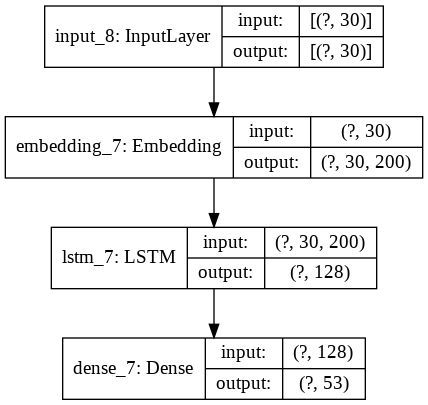

In [ ]:
# The following script prints the architecture of our neural network:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

###**8. Increasing the ephochs hyper-parameter with a batch size of 64**

In [ ]:
# From the figure above, you can see that the output layer only contains 1 dense layer with 53 neurons. Let's now train our model:

history = model.fit(X_train, y_train, batch_size=64, epochs=epochs, verbose=1, callbacks=early_stopping, validation_split=0.2)

Epoch 1/100
1765/1765 [==============================] - 10s 6ms/step - loss: 0.0753 - acc: 0.3041 - val_loss: 0.0451 - val_acc: 0.6096
Epoch 2/100
1765/1765 [==============================] - 10s 6ms/step - loss: 0.0322 - acc: 0.7340 - val_loss: 0.0193 - val_acc: 0.8555
Epoch 3/100
1765/1765 [==============================] - 10s 5ms/step - loss: 0.0168 - acc: 0.8687 - val_loss: 0.0112 - val_acc: 0.9107
Epoch 4/100
1765/1765 [==============================] - 10s 5ms/step - loss: 0.0112 - acc: 0.9134 - val_loss: 0.0080 - val_acc: 0.9337
Epoch 5/100
1765/1765 [==============================] - 10s 6ms/step - loss: 0.0084 - acc: 0.9341 - val_loss: 0.0066 - val_acc: 0.9407
Epoch 6/100
1765/1765 [==============================] - 9s 5ms/step - loss: 0.0069 - acc: 0.9442 - val_loss: 0.0054 - val_acc: 0.9523
Epoch 7/100
1765/1765 [==============================] - 10s 5ms/step - loss: 0.0059 - acc: 0.9502 - val_loss: 0.0048 - val_acc: 0.9534
Epoch 8/100
1765/1765 [==========================

###**Summary:**
######**The steps taken to improve the model are itemized below**

>* Tensorflow version 2.0.0 is installed, and because keras will not work with this out of the box, we have to use tensorflow keras libraries

>* We reduced our classes by filtering out to what we call 'GRP_Others' those classes with very few samples (this is the help us when we are taking care of class imbalance)


>* Performing text pre-processing (by text lowering, noise/stopwards removal and normalization by stemming)


>* Adjusting the length of sentences(the maxlen hyper-parameter), keeping it low


>* Taking care of the imbalance in the classes with RandomOverSampling:

We found that undersampling gave us a model with accuracy in the fifties but oversampling gave over 90%. ( I believe that in this case not reducing the actual sample numbers in the classes with lots of samples gave the model the much needed strength. Just to be clearer, using SMOTE gave us about 70%, while RandomOverSampling did the magic by landing us in the nineties region in model performance(because we have more trainable parameter).


>* Adding Early Stoping callback parameter gave the best number of iterations


>* Adding dropout to make the model a bit more complex


>* Increasing the ephochs hyper-parameter with a batch size of 64

##**( 2 ) Interpretation and Recommendations**

###**a. Provide interpretations from the model and report the final model evaluation metrics**




######**Model Evaluation and Plots**

In [ ]:
# Let's now evaluate our model on the test set:

score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

1103/1103 [==============================] - 3s 3ms/step - loss: 0.0028 - acc: 0.9689
Test Score: 0.002835427178069949
Test Accuracy: 0.9689412713050842


Our model achieves an accuracy of about 97% which is pretty impressive

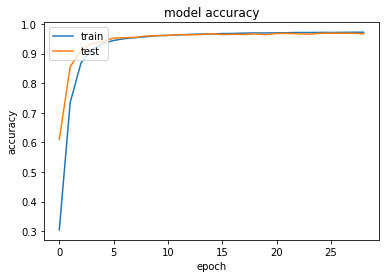

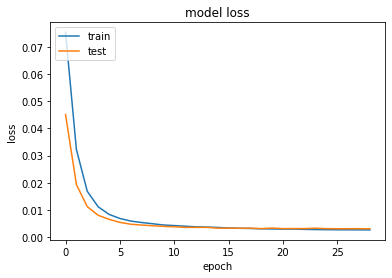

In [ ]:
# Finally, we will plot the loss and accuracy values for training and test sets to see what happened to our model

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

######**Observation**

As can be seen the model is not overfitting on the validation set. Therefore, the model should performance well on unseen data, it is a good fit

######**Predict and reporting**

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

Y_pred = model.predict(X_test)
y_pred = np.rint(Y_pred)
y_pred = np.argmax(Y_pred,axis=1)
y_test = np.argmax(y_test,axis=1)
print('  Classification Report:\n',classification_report(y_test,y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.74      0.85       687
           1       1.00      1.00      1.00       621
           2       0.99      1.00      0.99       636
           3       1.00      1.00      1.00       661
           4       0.97      0.97      0.97       624
           5       0.99      1.00      0.99       656
           6       1.00      0.98      0.99       633
           7       1.00      1.00      1.00       701
           8       0.99      1.00      1.00       709
           9       1.00      1.00      1.00       672
          10       1.00      1.00      1.00       648
          11       0.96      1.00      0.98       674
          12       0.98      0.99      0.98       665
          13       1.00      0.97      0.98       671
          14       1.00      1.00      1.00       663
          15       0.99      1.00      1.00       645
          16       0.99      1.00      1.00       665
 

######**Observation**
From our classification report: 

1. Filtering Groups that have between 1 - 6 samples into GRP_Others, combined with random oversampling with focus on the minority classes the model could predict on all labels with over 90% in precisions (with some actually at a 100%). And the model accuracy and f1-score of 97% actually agrees to that (i.e. F1-score being the weighed average of our precision and recall)
2. We did filtering between 1 - 15 samples into GRP_Others before now, the model was 96%

It is worth noting that the last group label 52 is the number 53rd class which is GRP_Others "

###**b. Report the recommendations, summarize the project and mention identified next steps**

######**Project Summary:**

######**i- Recommendation**
In a production environment, I would recommend filtering Groups with 1 - 6 samples into 'GRP_Other' over higher filterings or using the whole 74 classes, as we have a balance of predictions on more labels and a good accuracy leaving only a few Groups are to be manually sorted out in 'GRP_Others'.

 <h3><b>*This is wrong, please see a correction one at the end*</b></h3>
 
######**ii- summarizing the project** 
In the business domain we were told that L1/L2 resolves about 54% of the incidents but before that they need to do the classification manually and this take them about 26day based on our calculation since they have to review about 30% of the incidents(this actually could be seen to be there accuracy, since there make lots of mis-classifications)

But with the Machine Learning Classification and accuracy of 97%; by proportionality we can say if 30% manually accuracy attends to 30% of the total incidents in the dataset and it took 26days to classify them with so much errors, then our model's 97% accuracy can do a 97% incident classification and this will be in a few minutes with fewer errors.

With the analogy above, out model will allow L1/L3 to concentrate on resolving the incidents rather than classification. 
Furthermore: If they were resolving 54% of the incidents when they were manually classifying 30%, now that the model is classifying 97%; by proportionality they should be resolving about 174.6% of incidents (this is practically not possible though, but theoretically, the point is they should resolve much more than before). And so, “Keep the lights on” to ensure there is no impact on the business operations.

######**iii- Identifying next steps**

The next identified step is to deploy the model, and the options are:

1. As a standalone executable file - recommended for batch mode
2. As an on-prem application exposed as an API (e.g. Flask)
3. As a container based API in Azure or AWS container registry
4. Implemented as an API built on Azure ML or AWS SageMaker


To deploy in a production environment I would do the following using step 3 above:

1. Train this NLP model (with a transformer LSTM Neural Network)
2. Create a full-stack application using python rapper or Flask
3. Containerize using docker and test locally
4. Deploy app on Google Cloud using Kubernetes
5. Create a CI/CD architecture to continually train model on live data




<h1> <b>FINAL PRESENTATION</b></h1>

####**After the 3 submission (or Milestone 3); I realizes that the model is overfitting on the test data because the test data was also upsampled(i.e. dataset was oversampled before splitting). So, we will re-process our dataset and only oversample the training set.**



####**Let's build the model experimenting with various hyper-parameters and their values**
Parameters like: optimisers, loss functions, epochs, learning rate, batch size, checkpointing, early stopping 

####**Loading data afresh**

In [95]:
# Read data
capstoneNLP_DF = pd.read_excel(project_path+'input_data.xlsx')

In [96]:
capstoneNLP_DF.dtypes

Short description    object
Description          object
Caller               object
Assignment group     object
dtype: object

In [97]:
# Display shape and header

print(capstoneNLP_DF.shape)
capstoneNLP_DF.head()

(8500, 4)


,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [98]:
# Descriptive statistics gives us a lot more insight, just like knowing that 2,948 Callers generated these 8,491 tickets
capstoneNLP_DF.describe().T

,count,unique,top,freq
Short description,8492,7481,password reset,38
Description,8499,7817,the,56
Caller,8500,2950,bpctwhsn kzqsbmtp,810
Assignment group,8500,74,GRP_0,3976


#####**Concatenate necessary fields and drop unnecessary ones**

Not all the source text is important, so we need to concatenate the useful ones and drop the un-necessary ones.

In [99]:
# Concatenate fields
capstoneNLP_DF['Text'] = capstoneNLP_DF['Short description'] + capstoneNLP_DF['Description']

# Dropping unnecessary fields
capstoneNLP_DF = capstoneNLP_DF.drop(['Short description','Description','Caller'], 1)

# Renaming the "Assignment group" for ease of usage
capstoneNLP_DF = capstoneNLP_DF.rename(columns = {"Assignment group": "Groups"})

capstoneNLP_DF.head()

,Groups,Text
0,GRP_0,login issue-verified user details.(employee# &...
1,GRP_0,outlook\r\n\r\nreceived from: hmjdrvpb.komuayw...
2,GRP_0,cant log in to vpn\r\n\r\nreceived from: eylqg...
3,GRP_0,unable to access hr_tool pageunable to access ...
4,GRP_0,skype error skype error


In [100]:
# Check for null data
print(capstoneNLP_DF.isnull().any(axis = 0))

Groups    False
Text       True
dtype: bool


In [101]:
########### PREPROCESS, REMOVE: NOISE, NUMBERS, EMAIL, WEB LINKS, WHITESPACE, TRAILING/PRECEEDING SPACES, SPECIAL CHARACTERS. THEN NORMALISE
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords

nltk.download('stopwords')
set(stopwords.words('english'))
nltk.download('punkt')
nltk.download('wordnet')

import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)


capstoneNLP_DF['cleanText']=capstoneNLP_DF['Text'].map(lambda s:preprocess(s))

capstoneNLP_DF = capstoneNLP_DF.drop(['Text'], 1)

capstoneNLP_DF.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Groups,cleanText
0,GRP_0,login issue verified user details employee man...
1,GRP_0,outlook received hmjdrvpb komuaywn gmail com h...
2,GRP_0,cant log vpn received eylqgodm ybqkwiam gmail ...
3,GRP_0,unable access hr_tool pageunable access hr_too...
4,GRP_0,skype error skype error


In [102]:
# Check for null data
print(capstoneNLP_DF.isnull().any(axis = 0))

Groups       False
cleanText    False
dtype: bool


In [103]:
# drop duplicates, and reset index
#capstoneNLP_DF.drop_duplicates(subset="cleanText", inplace=True)
#capstoneNLP_DF.reset_index(drop=True, inplace=True)
#capstoneNLP_DF

In [104]:
capstoneNLP_DF.shape

(8500, 2)

In [105]:
### we have 74 classes

groupy2 = capstoneNLP_DF.groupby('Groups').size().sort_values(ascending=False)
groupy2

Groups
GRP_0     3976
GRP_8      661
GRP_24     289
GRP_12     257
GRP_9      252
          ... 
GRP_67       1
GRP_61       1
GRP_73       1
GRP_35       1
GRP_70       1
Length: 74, dtype: int64

In [106]:
#We filter out classes with 1 - 6 samples
capstoneNLP_DF_LTS = capstoneNLP_DF[capstoneNLP_DF['Groups'].map(capstoneNLP_DF['Groups'].value_counts()) < 7]

In [107]:
groupy2 = capstoneNLP_DF_LTS.groupby('Groups').size().sort_values(ascending=False)
groupy2

Groups
GRP_59    6
GRP_46    6
GRP_49    6
GRP_43    5
GRP_66    4
GRP_32    4
GRP_68    3
GRP_63    3
GRP_58    3
GRP_56    3
GRP_38    3
GRP_72    2
GRP_57    2
GRP_54    2
GRP_69    2
GRP_71    2
GRP_67    1
GRP_64    1
GRP_61    1
GRP_70    1
GRP_35    1
GRP_73    1
dtype: int64

In [108]:
# Replacing the groups that are now seen in groupy2 anyhwere they are found in the main dataset (capstoneNLP_DF) calling them GRP_OTHERS

capstoneNLP_DF_prep = capstoneNLP_DF.replace({'GRP_59':'GRP_OTHERS','GRP_46':'GRP_OTHERS','GRP_49':'GRP_OTHERS','GRP_43':'GRP_OTHERS','GRP_66':'GRP_OTHERS','GRP_32':'GRP_OTHERS','GRP_68':'GRP_OTHERS','GRP_63':'GRP_OTHERS','GRP_58':'GRP_OTHERS','GRP_56':'GRP_OTHERS','GRP_38':'GRP_OTHERS','GRP_72':'GRP_OTHERS','GRP_57':'GRP_OTHERS','GRP_54':'GRP_OTHERS','GRP_69':'GRP_OTHERS','GRP_71':'GRP_OTHERS','GRP_67':'GRP_OTHERS','GRP_64':'GRP_OTHERS','GRP_61':'GRP_OTHERS','GRP_70':'GRP_OTHERS','GRP_35':'GRP_OTHERS','GRP_73':'GRP_OTHERS'})

# 'GRP_51':'GRP_OTHERS','GRP_55':'GRP_OTHERS','GRP_52':'GRP_OTHERS','GRP_53':'GRP_OTHERS','GRP_65':'GRP_OTHERS','GRP_50':'GRP_OTHERS','GRP_44':'GRP_OTHERS','GRP_36':'GRP_OTHERS',

In [109]:
capstoneNLP_DF_prep.tail()

,Groups,cleanText
8495,GRP_29,emails coming mail received avglmrts vhqmtiua ...
8496,GRP_0,telephony_software issuetelephony_software issue
8497,GRP_0,vip windows password reset tifpdchb pedxruyfvi...
8498,GRP_62,machine estã funcionandoi unable access machin...
8499,GRP_OTHERS,mehreren lassen sich verschiedene prgramdntyme...


In [110]:
# Length of each cleanText
capstoneNLP_DF_prep['length'] = capstoneNLP_DF_prep['cleanText'].apply(lambda x: len(x.split(" ")))
capstoneNLP_DF_prep.head()

,Groups,cleanText,length
0,GRP_0,login issue verified user details employee man...,23
1,GRP_0,outlook received hmjdrvpb komuaywn gmail com h...,20
2,GRP_0,cant log vpn received eylqgodm ybqkwiam gmail ...,12
3,GRP_0,unable access hr_tool pageunable access hr_too...,7
4,GRP_0,skype error skype error,4


In [111]:
# Converting categorical labels to numerical format and call them 'Target'
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(capstoneNLP_DF_prep['Groups'])
capstoneNLP_DF_prep['Target'] = le.transform(capstoneNLP_DF_prep['Groups'])
capstoneNLP_DF_prep.tail()

,Groups,cleanText,length,Target
8495,GRP_29,emails coming mail received avglmrts vhqmtiua ...,16,22
8496,GRP_0,telephony_software issuetelephony_software issue,3,0
8497,GRP_0,vip windows password reset tifpdchb pedxruyfvi...,11,0
8498,GRP_62,machine estã funcionandoi unable access machin...,12,47
8499,GRP_OTHERS,mehreren lassen sich verschiedene prgramdntyme...,16,52


In [112]:
capstoneNLP_DF_prep["length"].mean()

21.93094117647059

####**Saved cleaned dataset**

In [113]:
#capstoneNLP_DF_prep.to_csv(project_path+"capstoneNLP_DF.csv", index=False)

####**Load cleaned dataset again**

In [114]:
#capstoneNLP_DF_prep = pd.read_csv(project_path+"capstoneNLP_DF.csv")
#capstoneNLP_DF_prep.tail()

In [115]:
capstoneNLP_DF_prep.dtypes

Groups       object
cleanText    object
length        int64
Target        int64
dtype: object

In [116]:
###################### Hyper-parameters and their values###############

num_classes = 53
epochs = 1000
batch_size = 64


feature = 5000
embedding_size = 300
maxlen = 25 # Max Lenth of sentence to pad to
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [117]:
#Apply Tokenizer and get indices for words
tokenizer = Tokenizer(num_words=feature, oov_token=oov_tok)
tokenizer.fit_on_texts(list(capstoneNLP_DF_prep['cleanText']))
X = tokenizer.texts_to_sequences(capstoneNLP_DF_prep['cleanText'])
print("Number of Samples:", len(X))
print(X[0])
X = pad_sequences(X, maxlen = maxlen, padding=padding_type, truncating=trunc_type)
y = np.asarray(capstoneNLP_DF_prep['Target'])
print("Number of Labels: ", len(y))
print(y[0])

word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

Number of Samples: 8500
[28, 18, 167, 15, 153, 176, 80, 36, 338, 15, 36, 17, 7, 516, 15, 28, 75, 310, 248, 46, 28, 18, 250]
Number of Labels:  8500
0


{'<OOV>': 1,
 'com': 3,
 'company': 4,
 'job': 2,
 'password': 7,
 'please': 8,
 'received': 6,
 'scheduler': 10,
 'tool': 5,
 'yes': 9}

The tokenizer encouter some upseen words in our corpus or features of 5000 words and those words are converted to <OOV> and according to the priority above <OOV>:1 means there are common

In [118]:
# Let see our clean_text number 11th; before and after padding
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
print(decode_article(X[10]))
print('---------------------')
print(capstoneNLP_DF_prep['cleanText'][10])

engineering tool says connected unable submit <OOV> tool says connected unable submit reports ? ? ? ? ? ? ? ? ? ? ? ?
---------------------
engineering tool says connected unable submit reportsengineering tool says connected unable submit reports


See that some unseen word has been replaced with <OOV> and pre/post padding done with '?' at the begining or ending of the sentence

In [119]:
#Actual Vocabulary size and number of words
num_words = len(tokenizer.word_index) + 1
vocab_size = num_words
print(num_words)

17754


In [120]:
#Get Glove Word Embeddings
EMBEDDING_FILE = project_path+'glove.6B.300d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 300))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [121]:
len(embeddings.values())

400000

In [ ]:
#########-----To run SMOTE model skip at this point to SMOTE below

####**Dealing with imbalance in the classes using RamdomOversampling**
RandomOverSampling runs so slowly perhaps because of the much number of samples, so we will run just one iteration with it and thereafter use SMOTE to do all other iterations

Splitting our X and y datasets

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=13, stratify=y)

In [63]:

ros = RandomOverSampler(sampling_strategy='auto',random_state=0)
X_train, y_train = ros.fit_sample(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [64]:
# onehot encoding the upsampled test label
#y_train = to_categorical(y_train, num_classes)

y_train = pd.get_dummies(y_train)
#y_train_labels = y_train.columns

In [65]:
# Checkpoint Best Neural Network Model Only
from tensorflow.keras.callbacks import ModelCheckpoint
filepath= project_path+"weights.bestRANDOM.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
# implementing early stopping of the model fitting process
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

In [73]:
#model building
import tensorflow as tf
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128, dropout=0.2)(embedding_layer)
dense_layer_1 = Dense(num_classes, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


# Let's print the model summary:
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 22)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 200)           3550600   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
dense (Dense)                (None, 53)                6837      
Total params: 3,725,885
Trainable params: 175,285
Non-trainable params: 3,550,600
_________________________________________________________________
None


In [74]:
history = model.fit(X_train, y_train, batch_size=64, epochs=epochs, verbose=0, callbacks=[early_stopping,callbacks_list], validation_split=0.2)


Epoch 00001: val_acc improved from -inf to 0.00000, saving model to /content/drive/My Drive/AIML/CapstoneProjectNLP/weights.bestRANDOM.hdf5

Epoch 00002: val_acc improved from 0.00000 to 0.07634, saving model to /content/drive/My Drive/AIML/CapstoneProjectNLP/weights.bestRANDOM.hdf5

Epoch 00003: val_acc improved from 0.07634 to 0.09535, saving model to /content/drive/My Drive/AIML/CapstoneProjectNLP/weights.bestRANDOM.hdf5

Epoch 00004: val_acc improved from 0.09535 to 0.09644, saving model to /content/drive/My Drive/AIML/CapstoneProjectNLP/weights.bestRANDOM.hdf5

Epoch 00005: val_acc improved from 0.09644 to 0.10846, saving model to /content/drive/My Drive/AIML/CapstoneProjectNLP/weights.bestRANDOM.hdf5

Epoch 00006: val_acc improved from 0.10846 to 0.11065, saving model to /content/drive/My Drive/AIML/CapstoneProjectNLP/weights.bestRANDOM.hdf5

Epoch 00007: val_acc improved from 0.11065 to 0.12542, saving model to /content/drive/My Drive/AIML/CapstoneProjectNLP/weights.bestRANDOM.

In [75]:
# Let's now evaluate our model on the test set that was not oversampled:
# But we need to first onehot encode the test label

# num_classes = 53
#y_test = to_categorical(y_test, num_classes)


y_test = pd.get_dummies(y_test)
#y_test_labels = y_test.columns

In [76]:
# evaluate
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

54/54 [==============================] - 1s 13ms/step - loss: 0.1008 - acc: 0.5818
Test Score: 0.10078877210617065
Test Accuracy: 0.5817646980285645


####**Dealing with imbalance in the classes using SMOTE**
SMOTE trains faster, so we will do our numerous iterations and adjustment of hyper-parameters here

In [122]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=13, stratify=y)


smote = SMOTE(ratio='minority', random_state=0)
#smote = SMOTE(sampling_strategy='auto', random_state=0)
X_train, y_train = smote.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [123]:
# onehot encoding the upsampled test label
#y_train = to_categorical(y_train, num_classes)

y_train = pd.get_dummies(y_train)

In [124]:
# Checkpoint Best Neural Network Model Only
from tensorflow.keras.callbacks import ModelCheckpoint
filepath= project_path+"weights.bestSMOTE.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [125]:
# early stopping implementating
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20)

In [126]:
#model building
import tensorflow as tf
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, embedding_size, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128, dropout=0.5)(embedding_layer)
dense_layer_1 = Dense(num_classes, activation='softmax')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

#adam = tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8) ------ defining our learning rate gave us a poor model about 44%


# Scheduler did not work well in this problem, the model performace was zero
# Learning rate decay / scheduling 
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=1e-2,
#    decay_steps=10000,
#    decay_rate=0.9)
#optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

# we resorted to using inbuild optimizers (they have a better adaptive learning)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])  # adam is performing better than rmsprop, so we stay on adam

# Let's print the model summary:
print(model.summary())

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 25, 300)           5326200   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_4 (Dense)              (None, 53)                6837      
Total params: 5,552,685
Trainable params: 226,485
Non-trainable params: 5,326,200
_________________________________________________________________
None


In [127]:
# fit model
history = model.fit(X_train, y_train, batch_size=64, epochs=epochs, verbose=0, callbacks=[early_stopping,callbacks_list], validation_split=0.2)

# Let's now evaluate our model on the test set that was not oversampled, but we need to first onehot encode the test label
#y_test = to_categorical(y_test, num_classes)
y_test = pd.get_dummies(y_test)

score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])


Epoch 00001: val_acc improved from -inf to 0.88521, saving model to /content/drive/My Drive/AIML/CapstoneProjectNLP/weights.bestSMOTE.hdf5

Epoch 00002: val_acc improved from 0.88521 to 0.94486, saving model to /content/drive/My Drive/AIML/CapstoneProjectNLP/weights.bestSMOTE.hdf5

Epoch 00003: val_acc improved from 0.94486 to 0.97343, saving model to /content/drive/My Drive/AIML/CapstoneProjectNLP/weights.bestSMOTE.hdf5

Epoch 00004: val_acc did not improve from 0.97343

Epoch 00005: val_acc did not improve from 0.97343

Epoch 00006: val_acc did not improve from 0.97343

Epoch 00007: val_acc did not improve from 0.97343

Epoch 00008: val_acc did not improve from 0.97343

Epoch 00009: val_acc did not improve from 0.97343

Epoch 00010: val_acc did not improve from 0.97343

Epoch 00011: val_acc did not improve from 0.97343

Epoch 00012: val_acc did not improve from 0.97343

Epoch 00013: val_acc did not improve from 0.97343

Epoch 00014: val_acc did not improve from 0.97343

Epoch 00015:

In [128]:
#### VARIOUS ITERATION RESULTS on Model performance

####-1  loss = binary_crossentropy , more complex model (dropout =0.5)(with early stopping patience=10) 
#===========================================================================================

### Batch size = 128 ----Maxlen-22
#-------------------
#rmsprop optimizer gave 63% 
#adam optimizer gave 59%
#adam optimizer gave 65% ----(with post padding, and unseen words in our corpus replaceed) , early stopping patience=20 
#sgd optimizer gave 44% 
#adadelta optimizer gave 38% 


### Batch size = 100 ---Maxlen-22
#------------------
#rmsprop optimizer gave 65.8 ----(with post padding, and unseen words in our corpus replaceed), early stopping patience = 20
#rmsprop optimizer gave 62%
#adam optimizer gave 61%
#adam optimizer gave 64.2% ----(with post padding, and unseen words in our corpus replaceed) , early stopping patience=20
#sgd optimizer gave 44% 
#adadelta optimizer gave 38% 



### Batch size = 64 ---Maxlen-22
#------------------
#rmsprop optimizer gave 62% 
#rmsprop optimizer gave 64.7% ----(with post padding, and unseen words in our corpus replaceed) , early stopping patience=20
#adam optimizer gave 66.2% ----(with post padding, and unseen words in our corpus replaceed) , early stopping patience=20
#adam optimizer gave 61% 
#sgd optimizer gave 44% 
#adadelta optimizer gave 3% 



### Batch size = 32 (with early stopping patience=20) ----Maxlen-22
#-------------------
#rmsprop optimizer gave 64% 
#rmsprop optimizer gave 63.5% ----(with post padding, and unseen words in our corpus replaceed) 
#adam optimizer gave 63% 
#adam optimizer gave 64.8% ----(with post padding, and unseen words in our corpus replaceed) 
#adam optimizer gave 62.7% ----(with pre padding, and unseen words in our corpus replaceed) 


### Batch size = 10 ---Maxlen-22
#-------------------
#adam optimizer gave 59%


### Batch size = 64 (the best) , post padding, and unseen words in our corpus replaceed
#--------------------
#adam optimizer gave 64.8% ---Maxlen = 50
#adam optimizer gave 62.9% ---Maxlen = 30
#adam optimizer gave 65.1% ---Maxlen = 25
#adam optimizer gave 64.9% ---Maxlen = 20
#adam optimizer gave 64.3% ---Maxlen = 22 (The first time was 66.2%)
#adam optimizer gave 64.5% ---Maxlen = 22 (Embeddings file with 300 dim, all other iterations were done with 200 dim)
#adam optimizer gave 65.7% ---Maxlen = 25 (Embeddings file with 300 dim)


####-2 loss = categorical_crossentropy, more complex model (dropout =0.5), relu activation, increased early stopping patience(15)
#=======================================================================================================================================
### Batch size = 128 ---Maxlen-22
#-------------------
#rmsprop gave 59.5% 
#adam gave 59.1% 

### Batch size = 64 ---Maxlen-22
#------------------
#rmsprop optimizer gave 60.8%
#adam optimizer gave 59.4%
#adam optimizer gave 64.6% ---Maxlen = 25 (Embeddings file with 300 dim), post padding (no relu, early stopping patiience= 20)


#### OBSERVATION:
# With Maxlen (maximum length of sentence allow) increased to 150, the model performed so poorly, and didnot even learn 

OBSERVATION: 

The true accuracy of the model when evaluated with the test set that has not been tampered with yielded a performance of about 65%

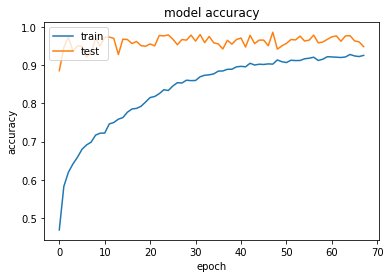

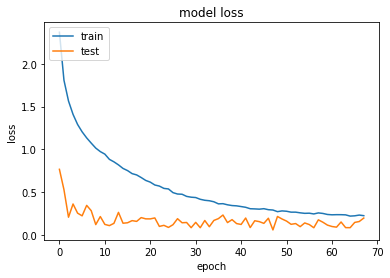

In [129]:
# So, we plot the loss and accuracy values for training and test sets to see what happened to our model

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

As can be seen the model generalized well on the training set(since it was upsampled), such that it didn't generalize but predicted well the unseen test set (that is few and un-sampled).

The loss eventually closes lower than what it began with showing that the model improved as it trained, the test loss is lower than the training's meaning that the model improved on the test set

In [130]:
from sklearn.metrics import classification_report,confusion_matrix

Y_pred = model.predict(X_test)
y_pred = np.rint(Y_pred)
#y_pred = np.argmax(Y_pred,axis=1)
#y_test = np.argmax(y_test, axis=1)
print('  Classification Report:\n',classification_report(y_test,y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       795
           1       0.33      0.17      0.22         6
           2       0.82      0.32      0.46        28
           3       0.29      0.33      0.31         6
           4       0.61      0.55      0.58        51
           5       0.50      0.45      0.47        29
           6       0.54      0.29      0.38        24
           7       0.40      0.25      0.31         8
           8       0.40      0.35      0.38        17
           9       0.89      1.00      0.94        16
          10       0.31      0.28      0.29        18
          11       0.45      0.33      0.38        43
          12       0.58      0.58      0.58        48
          13       0.00      0.00      0.00         7
          14       1.00      0.33      0.50         6
          15       0.00      0.00      0.00         6
          16       0.25      0.20      0.22         5
 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model was not able to predict on some classes because of insufficient 
samples.
Those Classes for which this model could not predict on, (perhaps before of the overwhelming influence of the more populated classes) Can be filtered out and another criterial used to model them.
However the F1 score is encouragingly 66% for a dataset that was be-deviled with lots of flaws)

And my model summary will essentially stay the same, only that some figures will change; as shown below

Relevance And implementability of the conclusions and recommendations
----------------------------------------------------------------------

Relevance to the project:
-------------------------
In the business domain we were told that L1/L2 resolves about 54% of the incidents but before that they need to do the classification manually and this take them more than 26days to classify the whole data set based on our calculation. Since they have to review about 30% of the incidents (a little over 2000 incidents) and each takes 15mins(this actually could be seen to be there accuracy, since they make lots of mis-classifications
But with the Machine Learning Classification accuracy was 65%; by proportionality we can say if 30% manual accuracy, attends to 30% of the total incidents in the dataset and it took 26days to classify them with so much errors, then our model’s 65% accuracy can do a 65% incident classification and this will be in a few minutes with fewer errors.
With the analogy above, out model will allow L1/L2 to concentrate on resolving the incidents rather than classification, and that goes for L3 too. Furthermore: If they were resolving 54% of the incidents when they were manually classifying 30%, now that the model is classifying at 65%; by proportionality they should be resolving about 117% of incidents (this is practically not possible though, but theoretically, the point is they should resolve much more than before). And so, “Keep the lights on” to ensure there is no impact on the business operations.

Implementability:
-----------------
We can deploy our saved model in real time so that the classification goes on when the users are sending in the incidents and the technical teams are busy trying to resolve them, we can make it :
1.	As a standalone executable file - recommended for batch mode
2.	As an on-prem application exposed as an API (e.g. Flask)
3.	As a container based API in Azure or AWS container registry
4.	Implemented as an API built on Azure ML or AWS SageMaker

But logically I will:
1.	Train this NLP model (with a transformer LSTM Neural Network)
2.	Create a full-stack application using python rapper or Flask
3.	Containerize using docker and test locally
4.	Deploy app on Google Cloud using Kubernetes
5.	Create a CI/CD architecture to continually train model on live data.

While the main model is been deployed, a smaller consisting of those classes that were not predicted in the main model, can be trained and deploy in real time along side the main model a technical team can be put together to classify manually GRP_OTHERS and to quickly address those services representing the classes with volumes of incidents; like doing a user friendly how-to manuals, or a video documentary of how to self resolve simpler issues

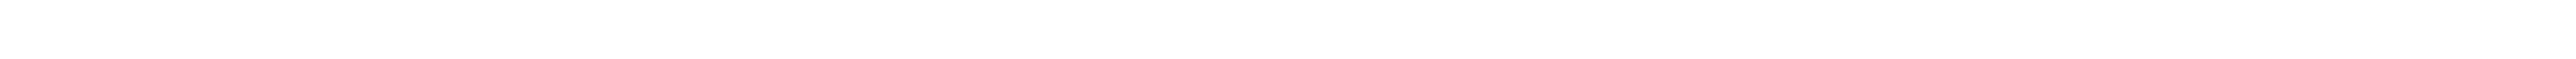